In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('./'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Make Phantom

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.25e-3,0.25e-3,0.25e-3),
            matrix_dims = (256,256,128),
            baseline = (1500, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1500, rho=1000, sigma=0, scale=0.001, label=0)
wire = tissue.Tissue(name='wire', c=1600, rho=1100, sigma=30, scale=0.0001, label=1)

pos = 0.016
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

test_phantom.add_tissue_sphere((0,-pos,0), 4, wire)
test_phantom.add_tissue_sphere((0,0,0), 2, wire)
test_phantom.add_tissue_sphere((0,pos,0), 8, wire)
test_phantom.add_tissue_sphere((pos,-pos,0), 8, wire)
test_phantom.add_tissue_sphere((pos,0,0), 4, wire)
test_phantom.add_tissue_sphere((pos,pos,0), 16, wire)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

In [3]:
test = test_phantom.get_complete()

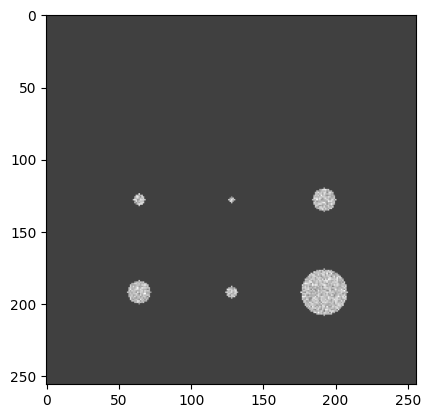

In [4]:
index = 64
plt.imshow(test[0, :, :, index], cmap='gray', vmin=1450, vmax=1650)

# Set up simulation

In [23]:
num_transducers = 2

transducers = [transducer.Focused(max_frequency = 1e6,
                                  elements = 128, 
                                  width = 15e-3,
                                  height =  15e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = (np.pi/2,np.pi/2),
                                  ray_num = (5,5),
                                  imaging_ndims = 3,
                                  focus_azimuth = 70e-3,
                                  focus_elevation = 100e-3,
                                  balance_3D = True,),
               transducer.Focused(max_frequency = 1e6,
                                  elements = 128, 
                                  width = 15e-3,
                                  height =  15e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = (np.pi/2,np.pi/2),
                                  ray_num = (5,5),
                                  imaging_ndims = 3,
                                  focus_azimuth = 70e-3,
                                  focus_elevation = 100e-3,
                                  balance_3D = False,)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

[1.11072073 0.55536037 0.         0.55536037 1.11072073]
[-0.78539816 -0.39269908  0.          0.39269908  0.78539816]
[-0.78539816 -0.39269908  0.          0.39269908  0.78539816]


In [24]:
transducer_pose = geometry.Transform(rotation=(np.pi * 0, np.pi * 0, np.pi * 0), translation=[0, 0, 0])
test_transducer_set.assign_pose(0, transducer_pose)
transducer_pose = geometry.Transform(rotation=(np.pi * 0, np.pi * 0, np.pi * 0), translation=[0, 0, 0])
test_transducer_set.assign_pose(1, transducer_pose)

In [25]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

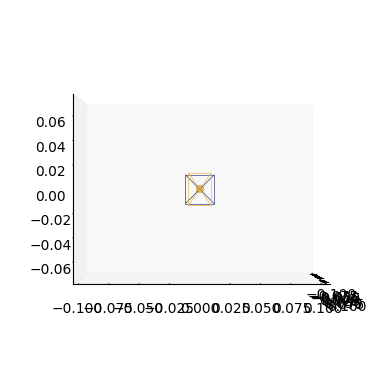

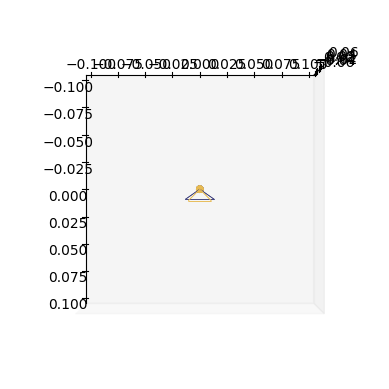

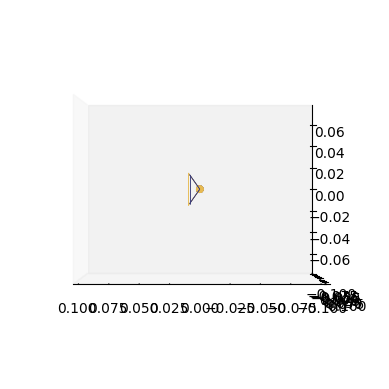

In [26]:
# test_transducer_set.plot_transducer_coords(scale = 0.1, phantom_coords = np.array((o3d.io.read_triangle_mesh(f"{parent}/assets/cardiac_TEE_phantom/03_esophagus.obj")).sample_points_uniformly(1000).points))
# test_transducer_set.plot_transducer_coords()
test_transducer_set.plot_transducer_fovs(view=(0,0))
test_transducer_set.plot_transducer_fovs(view=(90,0))
test_transducer_set.plot_transducer_fovs(view=(0,90))

In [28]:
simprops = simulation.SimProperties(
                grid_size   = (110e-3,20e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (16,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [32]:
test_experiment = experiment.Experiment(
                 simulation_path = f'volume_transducer_test',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

# Run Simulation

In [33]:
test_experiment = experiment.Experiment.load(f'volume_transducer_test')
test_experiment.run(dry=True)

Number of simulation results (0) is less than the expected number of simulation results (50), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


In [34]:
test_experiment.run(repeat=False)

running with 3 workers

preparation for sim    0 completed in  9.34 seconds
preparation for sim    1 completed in  8.94 seconds
preparation for sim   25 completed in  8.71 seconds
simulation             0 completed in 10.03 seconds
simulation            25 completed in 10.65 seconds
preparation for sim    2 completed in 10.29 seconds
preparation for sim   26 completed in 10.19 seconds
simulation             1 completed in 10.49 seconds
preparation for sim    3 completed in  9.86 seconds
simulation             2 completed in  9.69 seconds
preparation for sim    4 completed in  9.42 seconds
simulation            26 completed in  9.64 seconds
preparation for sim   27 completed in 10.25 seconds
simulation             3 completed in 12.56 seconds
preparation for sim    5 completed in  8.95 seconds
preparation for sim   28 completed in  9.28 seconds
simulation             4 completed in 13.92 seconds
simulation            27 completed in  8.88 seconds
simulation             5 completed in  9

# Reconstruction

In [35]:
test_experiment.add_results()

In [36]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [ ]:
# for i,result in tqdm.tqdm(enumerate(test_reconstruction.results)):
#     if result[0].shape[0] != 2477:
#         print(result[0].shape)
#         prit(i)
#         break

In [37]:
signals = test_reconstruction.get_signals(dimensions=3, matsize=128, downsample=1, workers=16, tgc=10)

100%|██████████| 50/50 [00:29<00:00,  1.70it/s]
2it [01:07, 33.78s/it]


In [38]:
from utils import utils

In [40]:
for i,signal in enumerate(signals):
    # signal = np.where(np.isnan(signal), 0, signal)
    utils.save_mrc(signal, f'test_transducer_signals_{i}.mrc')

In [ ]:
image = test_reconstruction.get_image(dimensions=3, matsize=128, downsample=0.5, workers=24, tgc=6)
# image = np.where(np.isnan(image), 0, image)
utils.save_mrc(image, 'output/cardiac_TEE_image.mrc')

In [ ]:
assert False

In [ ]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=128, downsample=0.5, workers=16, tgc=10)

In [ ]:
plt.imshow(signals[0], vmax=20000, cmap='gray')

In [ ]:
plt.imshow(signals[1], vmax=20000, cmap='gray')

In [ ]:
plt.imshow(signals[2], vmax=20000, cmap='gray')

In [ ]:
plt.imshow(signals[3], vmax=20000, cmap='gray')

In [ ]:
plt.imshow(signals[4], vmax=20000, cmap='gray')